In [1]:
import seaborn
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski

from scipy.spatial import distance
from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics

import pandas as pd
import molvs
import csv
from pprint import pprint

TODO: stahnout data jen pro EC50 a IC50 a vynest je proti pozadi a proti sobe

# Reading the data

In [2]:
CB1_data = []
with open("CB1_cannabinoid_receptor.csv") as f:
    reader = csv.reader(f, delimiter = ";", quotechar = '"')
    for line in reader:
        #print(line)
        CB1_data.append(line)
header = CB1_data[0]
CB1_data = CB1_data[1:]
CB1_data[0]

['CCCCC1=NN(CC1c2ccsc2)C(=O)NC(C)(C)c3ccccc3',
 'EC50',
 '39.81',
 '7.4',
 '369.53',
 '5.34']

In [18]:
CB1_smiles_measure = [[r[0], r[1]] for r in CB1_data]
CB1_smiles_measure[:5], len(CB1_smiles_measure)

([['CCCCC1=NN(CC1c2ccsc2)C(=O)NC(C)(C)c3ccccc3', 'EC50'],
  ['Cl.COc1cccc2c(cn(CC3CCCCC3)c12)C(=O)N4CCN5CCC[C@H]5C4', 'EC50'],
  ['CCCCCOc1ccc(C(=O)c2cccc3ccccc23)c4ccccc14', 'EC50'],
  ['Cc1ccc(cc1S(=O)(=O)N2CCCCC2)C(=O)Oc3cccc4cccnc34', 'EC50'],
  ['CC(C)NC(=O)c1cc(c2ccc(Cl)cc2)c(nc1Oc3ccc(F)c(F)c3)c4ccc(Cl)cc4Cl',
   'IC50']],
 1384)

In [19]:
CB1_mols = [Chem.MolFromSmiles(s) for s, m in CB1_smiles_measure if s]
CB1_measure = [m for s, m in CB1_smiles_measure if s]
CB1_mols[:5], len(CB1_mols), CB1_measure[:5], len(CB1_measure)

([<rdkit.Chem.rdchem.Mol at 0x7fea8c69fcb0>,
 1301,
 ['EC50', 'EC50', 'EC50', 'EC50', 'IC50'],
 1301)

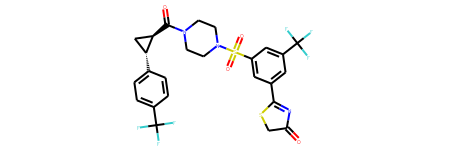

In [20]:
CB1_mols[666]

In [21]:
ZINC_smiles = []
with open("zincs1000.smi") as f:
    for line in f:
        ZINC_smiles.append(line.strip("\n"))

ZINC_smiles[:5]

['CN(C)CC(=O)NCc1cccc(OCc2ccccc2)c1',
 'CSCCN1CCC(C(=O)c2ccc3c(c2)NC(=O)C(C)O3)CC1',
 'CC(=O)N1CCCCC1C(=O)NC1CCCN(c2ncccn2)C1',
 'CNC(=O)C1(C)CCN(C(=O)c2csc(-c3cnn(-c4ccccc4)c3)n2)C1',
 'Fc1ccc2nc(-c3cccc(Cl)c3)sc2c1']

In [22]:
ZINC_mols = [Chem.MolFromSmiles(s) for s in ZINC_smiles if s]
ZINC_mols[0], len(ZINC_mols)

(<rdkit.Chem.rdchem.Mol at 0x7fea8b0663a0>, 1000)

# Standardization

In [23]:
isOrganic = Chem.MolFromSmarts('[#6]')
hasInorganic = Chem.MolFromSmarts('[!#6;!#7;!#8;!#16;!Cl;!F;!Br;!I]')

_s = molvs.Standardizer()
def standardisation(mol):
    mol = _s.standardize(mol)
    mol = _s.fragment_parent(mol)
    if mol.HasSubstructMatch(isOrganic) and not mol.HasSubstructMatch(hasInorganic):
        mol = _s.charge_parent(mol)
        mol = _s.stereo_parent(mol)
        return mol
    else:
        return None

In [24]:
CB1_supp = (standardisation(mol) for mol in CB1_mols if mol)
CB1_clean = [mol for mol in CB1_supp if mol]
len(CB1_clean)

1301

In [25]:
ZINC_supp = (standardisation(mol) for mol in ZINC_mols if mol)
ZINC_clean = [mol for mol in ZINC_supp if mol]
len(ZINC_clean)

1000

# Descriptors

I'll be using TPSA and clogP for the visulization of my compounds against ZINC compounds.

I'll first show all of the compounds against the ZINC background and then I'll highlight which of my compounds have measured IC50 and EC50.

In [26]:
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Descriptors
from matplotlib import pyplot as plt

In [13]:
CB1_descriptors = [[Descriptors.MolLogP(m), rdMolDescriptors.CalcTPSA(m), True] for m in CB1_clean]
CB1_descriptors = pd.DataFrame(CB1_descriptors, columns = ["cLogP", "TPSA", "isCB1"])


In [14]:
ZINC_descriptors = [[Descriptors.MolLogP(m), rdMolDescriptors.CalcTPSA(m), False] for m in ZINC_clean]
ZINC_descriptors = pd.DataFrame(ZINC_descriptors, columns = ["cLogP", "TPSA", "isCB1"])

In [15]:
all_descriptors = pd.concat([ZINC_descriptors, CB1_descriptors])

Text(0, 0.5, 'TPSA')

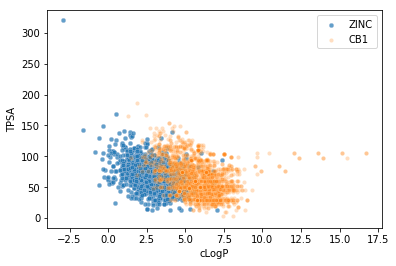

In [16]:
plt.scatter(ZINC_descriptors["cLogP"], ZINC_descriptors["TPSA"], edgecolors="lightsteelblue", linewidths=0.5, alpha=0.7, s=20, label="ZINC")
plt.scatter(CB1_descriptors["cLogP"], CB1_descriptors["TPSA"], edgecolors="navajowhite", linewidths=0.5, alpha=0.25, s=15, label="CB1")
plt.legend()
plt.xlabel("cLogP")
plt.ylabel("TPSA")


Text(0, 0.5, 'TPSA')

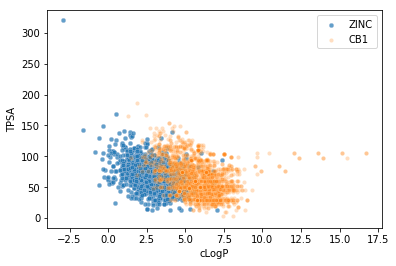

In [16]:
plt.scatter(ZINC_descriptors["cLogP"], ZINC_descriptors["TPSA"], edgecolors="lightsteelblue", linewidths=0.5, alpha=0.7, s=20, label="ZINC")
plt.scatter(CB1_descriptors["cLogP"], CB1_descriptors["TPSA"], edgecolors="navajowhite", linewidths=0.5, alpha=0.25, s=15, label="CB1")
plt.legend()
plt.xlabel("cLogP")
plt.ylabel("TPSA")


# PCA

In [34]:
lip_func = [Lipinski.NumHAcceptors, Lipinski.NumHDonors, Descriptors.ExactMolWt, Descriptors.MolLogP,
            rdMolDescriptors.CalcTPSA, Lipinski.NumRotatableBonds]
CB1_ro5 = [[f(mol) for f in lip_func] for mol in CB1_clean]

In [44]:
CB1_scaled = preprocessing.scale(CB1_ro5)
pca = decomposition.PCA(n_components=6)
pca.fit(CB1_scaled)
CB1_t = pd.DataFrame(pca.transform(CB1_scaled), columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6"])
print(pca.explained_variance_ratio_)

[0.45580375 0.24107574 0.18669113 0.07521346 0.02872452 0.01249139]


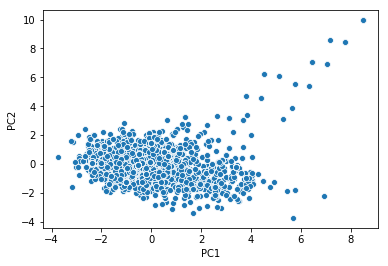

In [46]:
seaborn.scatterplot(x=CB1_t["PC1"], y=CB1_t["PC2"])

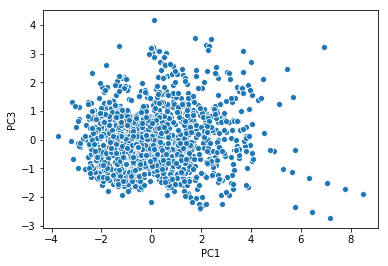

In [47]:
seaborn.scatterplot(x=CB1_t["PC1"], y=CB1_t["PC3"])

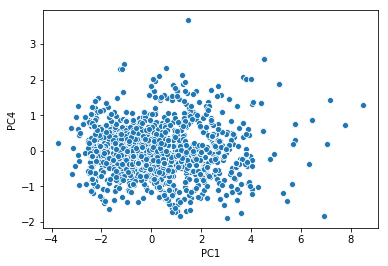

In [48]:
seaborn.scatterplot(x=CB1_t["PC1"], y=CB1_t["PC4"])

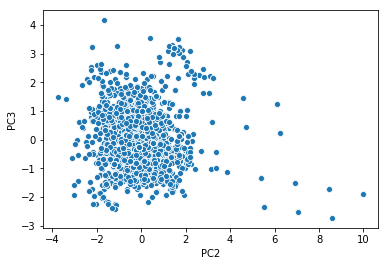

In [49]:
seaborn.scatterplot(x=CB1_t["PC2"], y=CB1_t["PC3"])

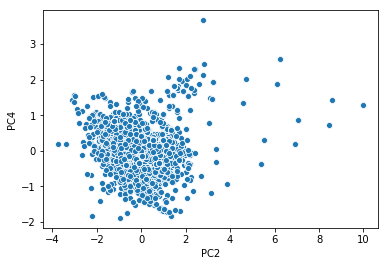

In [50]:
seaborn.scatterplot(x=CB1_t["PC2"], y=CB1_t["PC4"])

# MDS

In [22]:
CB1_fps = [Chem.GetMorganFingerprintAsBitVect(m,2,nBits=1024) for m in CB1_clean]

In [23]:
sparse_mat = distance.pdist(CB1_fps, metric="jaccard")
dist_mat = distance.squareform(sparse_mat)

In [24]:
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100, dissimilarity="precomputed")
CB1_mds = clf.fit_transform(dist_mat)

In [25]:
CB1_mds_res = pd.DataFrame(CB1_mds, columns=["x","y"])

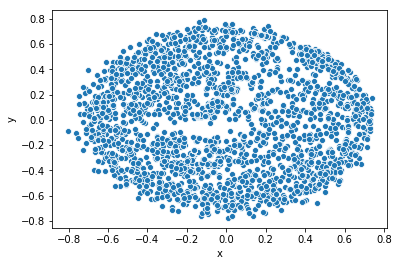

In [28]:
seaborn.scatterplot(x="x", y="y", data=CB1_mds_res)